# Assignment 2
**Group 5**

Group members:
- Moqian Chen (r0965473)
- Laurens Dergent (r0794288)
- Sarah Guilliams (r0751825)
- Yeabsera Kinfu (r0930148)
- Jorge Puertolas Molina (r0978889)
- Isabel Scholz (r1008561)

Link to the GitHub repository: https://github.com/LaurensDergent/DataAnalytics.git

!!! Add what worked and did not work well!!! => That you learned from this

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network.
For this assignment three methods are developed with the goal of pricing the games:
1. Building a CNN that does not take into consideration that some screenshots belong to the same game.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by using multiple screenshots of a game as input of a multi-branch CNN with a concatenated layer.
1. Building a CNN that takes into consideration that some screenshots belong to the same game by stitching the screenshots of a game together to create one large image. This large image is then fed into the CNN.  

First, some general pre-processing is discussed. This ensures that the same splits will be used for each method. Then, for each method the pre-processing steps are discussed. Then each model with the necessary evaluation criteria is built. Then, based on the the evaluation metric, the best of the three beforementioned methods is selected. Lastly, some interpretability techniques to get insights on the model is given. 

To start, the necessary packages and data are loaded in. The data with for each game the related price and images are included. Additionally, a path is created to where the images are stored on the local device.

In [1]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn import metrics

In [2]:
# Set the location of where the images are stored. Adjust to the correct location when running the code!

# For Methodologies 1 and 2
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'
# For Methodology 3
#image_location = 'D:/images/stitched'

#  Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

data1 = pd.DataFrame(data) #Make sure that the data has the DataFrame format
data1.head() #print the first 5 rows with data

appid     release                             title  price sentiment  \
0  2805630  2024-02-24                         BotMobile   1173  Positive   
1  2805610  2024-02-24  Just skill shooter 3: 2d edition    199  Positive   
2  2816420  2024-02-24                        Slime Drop    199      None   
3  2815670  2024-02-24               Path to the Creator    299      None   
4  2776190  2024-02-24                  Crowd Control VR   1179      None   

  reviews percentage                                               tags  \
0      10        100  [Action, Action-Adventure, Adventure, Casual, ...   
1      11         90  [2D, Action, Action RPG, Action-Adventure, Adv...   
2    None        NaN  [2D, Arcade, Casual, Clicker, Colorful, Cute, ...   
3    None        NaN  [2D, Action RPG, Adventure, Character Customiz...   
4    None        NaN  [360 Video, Arcade, Cartoony, Casual, Fantasy,...   

                                         screenshots  
0  [2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...  
1  [2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...  
2  [2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...  
3  [2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...  
4  [2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...

## Pre-processing
- Before fitting the models, do some data exploration

### Exploratory data analysis
- make an analysis how the prices are structured, by using a boxplot.
- explain that we first tested our models on a selection of the games, to get the code to work on for example 10% of the data. That is why we have this extra code here.

In [3]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(data1))
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)

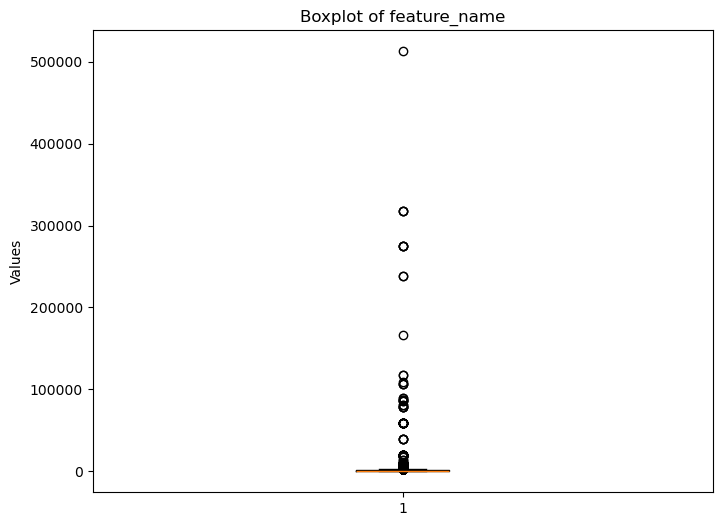

Q1:  199.0 Q2:  499.0 Q3:  998.0 Q4:  5999.0


In [4]:
#Make a boxplot of the feature 'price'
feature_data = selected_games['price']

# Create a boxplot using matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(feature_data)
plt.title('Boxplot of {}'.format('feature_name'))
plt.ylabel('Values')
plt.show()

#calculate some quantiles
Q1 = feature_data.quantile(0.25)
Q2 = feature_data.quantile(0.50)
Q3 = feature_data.quantile(0.75)
Q4 = feature_data.quantile(0.99)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

print('Q1: ', Q1, 'Q2: ', Q2, 'Q3: ', Q3, 'Q4: ', Q4)
#Based on these quantiles its clear that some of these outliers can be taken out.

From the boxplot we notice that there are some outliers, so the decision is made to remove all games higher that $100$ USD.
This can also be explained by the fact that there are bundles (explain further)
The dataset also includes 'bundle' games. these bundles contain multiple games. They have a very high price. As they are not in the scope of this model they are removed.

In [5]:
# Remove the games that have a price larger than 100 USD from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]


Notice that most of the games have a very low game price below 10 USD. 

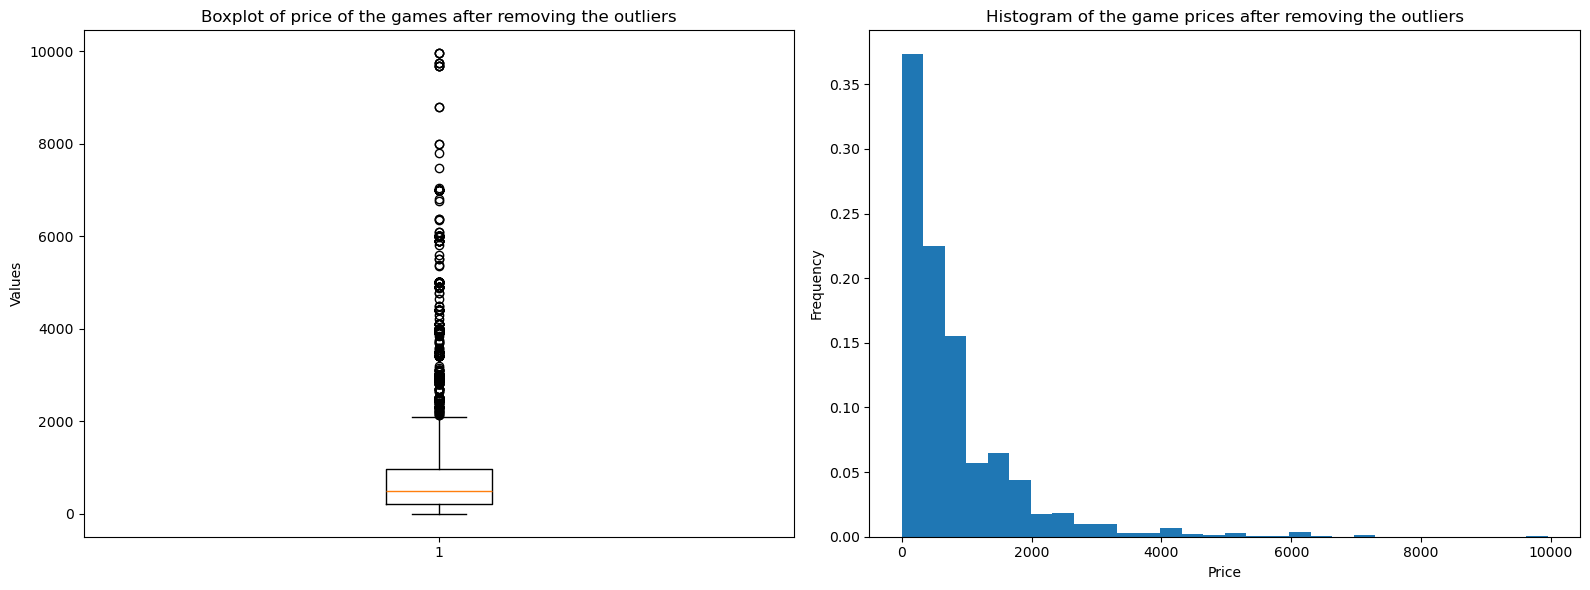

In [6]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Boxplot of the games without the outliers
ax[0].boxplot(selected_games_no_outliers["price"])
ax[0].set_title('Boxplot of price of the games after removing the outliers')
ax[0].set_ylabel('Values')

# Second subplot: Histogram
# Multiply y-axis values by 100 to represent percentages
ax[1].hist(selected_games_no_outliers['price'], weights=np.zeros_like(selected_games_no_outliers['price']) + 1. / selected_games_no_outliers['price'].size, bins=30)
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of the game prices after removing the outliers')

# Assuming 'target_variable' is the name of your target variable column in the dataframe 'data'
target_variable = selected_games_no_outliers['price']

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Because of the skewness of the data, there were still some games with large prices (for example prices above 20 USD). Another methodology that we tried but did not utilize due to bad results was undersampling. We split the training data up in games with prices higher and lower than 20 USD. Then, we randomy removed 50% of the games above 20 USD so that the model could focus on fitting the games below 20 USD better. However, this did not improve the results. Therefore, this example just continues to work with the training data set wituout any under- or oversampling.

Additionally, it should be noted, that corrupted images were removed in advance. When unzipping all of the images some images became corrupted. Therefore, we had to detect these corrupted images as the code otherwise did not properly run.

### Image augmentation

It is the same for the different methdologies

A key aspect of the pre-processing step is normalizing the images and performing some data augmentations (ex. rotations, flips, ...). When performing this pre-processing account must be taken of the fact that there are over 125k images available. This makes it very difficult to manually load in and augment the images. A workaround for this is by using the ImageDataGenerator function in combination with a flow_from_dataframe function (inspired by the following stackoverflow question: https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model). The ImageDataGenerator progressively loads images into the memory while training the model. Below the code is given for the data augmentation for all 3 methods. However the loading in of the data differs a bit between the different types of methods. So in the 3 proposed methodologies, some additional pre-processing is necessary.

In [7]:
# For the training images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

# For the validation images
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

#For the test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

### Some global parameters
Next, a defintion is made of some global parameters. This allows each user to specify these parameters according to preferences and to the machine that is being run on.
The decision was made to select a height and width of 224 by 224. The first reason for this is that many pre-trained models require a square input shape. Secondly, through research we noticed that 224 was a very common size. By selecting 224 the runtime of CNNs was still reasonable. If, however, the image size was increased by a little bit, then the run-time increased a lot very fast.

In [8]:
width = 224 
height = 224 
#height width
image_size = (height, width)

#batch size
batch_size = 32

## 1. CNN that does not take into consideration that images belong to the same game

### Pre-processing

#### Train - test split

A key aspect of this assignment is accounting for the fact that a game can have multiple images. Therefore, when splitting the data into the training, validation, test split, this split should be made based on the games and not the seperate images. For this assignment the decision was made to split our data 60/20/20. 

Note that in order to also create a dataset for validation, a train-test split must be performed two times. In the first split the test set is generated. In the second split, the training set from the initial split is used to generate a training and a validation dataset.

In [9]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

#### Developing the dataframe structure

As the flow_from_dataframe function is used, first, a dataset with in first column the screenshot (the feature) and in the second column the price (the target) is created for respectively the training, validation and test set.  

In [10]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

val_label_df = pd.DataFrame(val_data)


# Do the same for the test set
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

test_label_df = pd.DataFrame(test_data)

Next, apply the generators to the dataframes. These generators will be used as input.

In [11]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size,
                                              batch_size=batch_size)

Found 76623 validated image filenames.
Found 25876 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(
/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25576 validated image filenames.


Below an illustration is given on how the images are adapted by using ImageDataGenerator

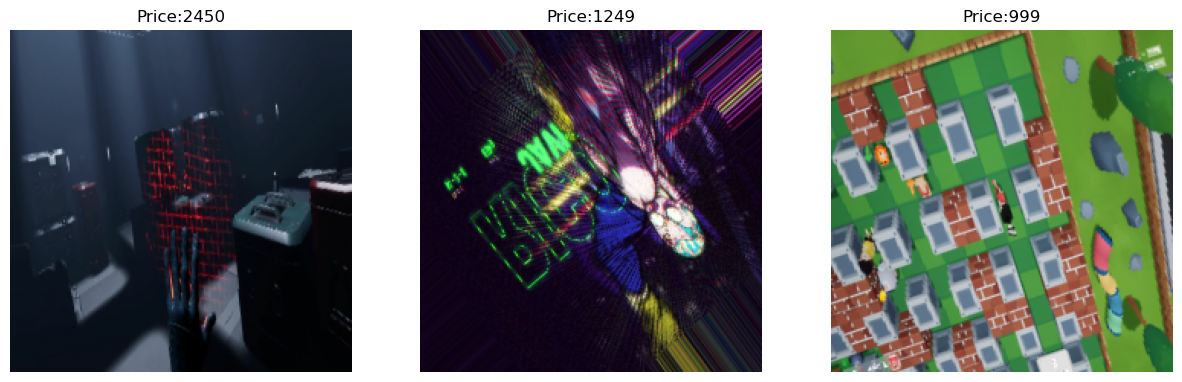

In [12]:
# Retrieve a batch of images from the train_generator
batch = train_generator.next()

# Get the images and labels from the batch
images = batch[0]
labels = batch[1]

# Set up the plot with three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Display the images horizontally
for i in range(3):
    axes[i].imshow(images[i])
    axes[i].set_title("Price:" + str(labels[i]))  # Assuming labels represent prices
    axes[i].axis('off')

plt.show()

### Architecture of the model

Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(height, width, 3))


base_model = ResNet50(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    input_tensor = inputs,
    pooling=None
)

# Freeze the base model
base_model.trainable = False

x = base_model(inputs, training=False)

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
x = layers.BatchNormalization()(x) # inspired by https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ 
outputs = layers.Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = keras.Model(inputs, outputs)


This code is to save a nice visualisation of the model. Then this visualisation should be put in this spot.

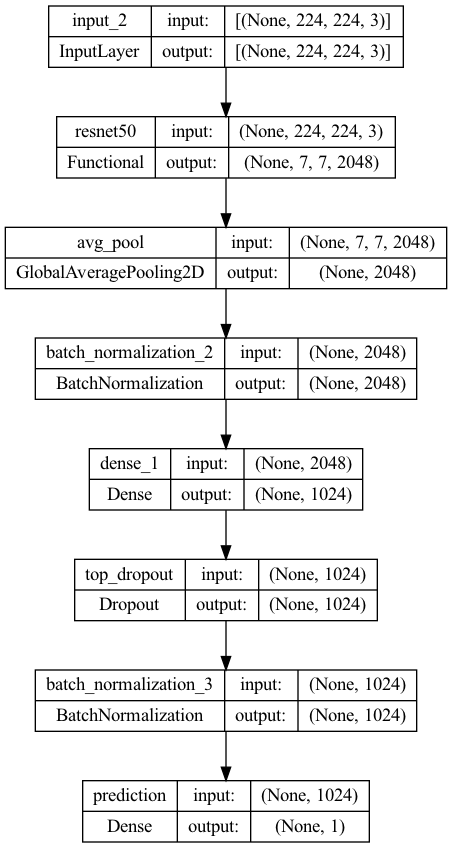

In [14]:
from keras.utils import plot_model
import pydot
#plot_model(model, "Method1.png", show_shapes=True)
#model.summary()

from IPython.display import Image

# Display the image with a relative path
Image(filename='Method1.png')

### Prevention of overfitting

Cannot use MAPE because there are prices equal to zero => will not work
How we are preventing overfitting:
- keeping track of a validation set and early stopping if the validation set has reached its minimum level (so the delta does not increase anymore)
- Dropout
- Batch normalization

Loss function: using rmse 
This depends on your loss function. In many circumstances it makes sense to give more weight to points further away from the mean--that is, being off by 10 is more than twice as bad as being off by 5. In such cases RMSE is a more appropriate measure of error. https://stats.stackexchange.com/questions/48267/mean-absolute-error-or-root-mean-squared-error 



As mentioned above, Cyclical Learning Rates enables our learning rate to oscillate back and forth between a lower and upper bound.

So, why bother going through all the trouble?

Why not just monotonically decrease our learning rate, just as we’ve always done?

The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.

Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.

Instead, we can use Cyclical Learning Rates to oscillate our learning rate between upper and lower bounds, enabling us to:

Have more freedom in our initial learning rate choices.
Break out of saddle points and local minima.
In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

 Loss function: the parameter that is used to optimize the model, i.e. the loss function is minimized by the model
 Metric: what is used to evaluate the model performance (this can be used to compare different models)

+ Used Huber
From Google : "Huber Loss is a popular loss function used in machine learning for regression tasks, particularly when dealing with outliers in the data. It combines the properties of both quadratic loss (squared error) and absolute loss (absolute error) to provide a more robust solution."

In [15]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam
from keras.losses import Huber

#set the CLR options
clr_step_size = int(4 * (len(train_generator)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 1e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0008)

# Adding an early stopping mechanism
EarlyStoppinng = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    start_from_epoch=3,
)

model.compile(optimizer=opt, loss=Huber(delta=1.0), metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")


Model is compiled


### Fitting the model

In [16]:
history = model.fit(
    train_generator,
    callbacks=[EarlyStoppinng, clr_triangular],
    steps_per_epoch=train_generator.n//batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps = val_generator.n//batch_size
)

Epoch 1/6


2024-05-22 23:29:03.571771: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2394/2394 [==============================] - 4839s 2s/step - loss: 651.4397 - mean_absolute_error: 651.9377 - val_loss: 662.4385 - val_mean_absolute_error: 662.9377
Epoch 2/6
2394/2394 [==============================] - 4869s 2s/step - loss: 636.2138 - mean_absolute_error: 636.7136 - val_loss: 661.6533 - val_mean_absolute_error: 662.1522
Epoch 3/6
2394/2394 [==============================] - 4852s 2s/step - loss: 635.4386 - mean_absolute_error: 635.9385 - val_loss: 663.2850 - val_mean_absolute_error: 663.7844
Epoch 4/6
2394/2394 [==============================] - 4840s 2s/step - loss: 635.0746 - mean_absolute_error: 635.5743 - val_loss: 662.2110 - val_mean_absolute_error: 662.7097
Epoch 5/6
2394/2394 [==============================] - 4843s 2s/step - loss: 635.4959 - mean_absolute_error: 635.9957 - val_loss: 664.1028 - val_mean_absolute_error: 664.6022
Epoch 5: early stopping


Plot a curve to analyse the learning rate

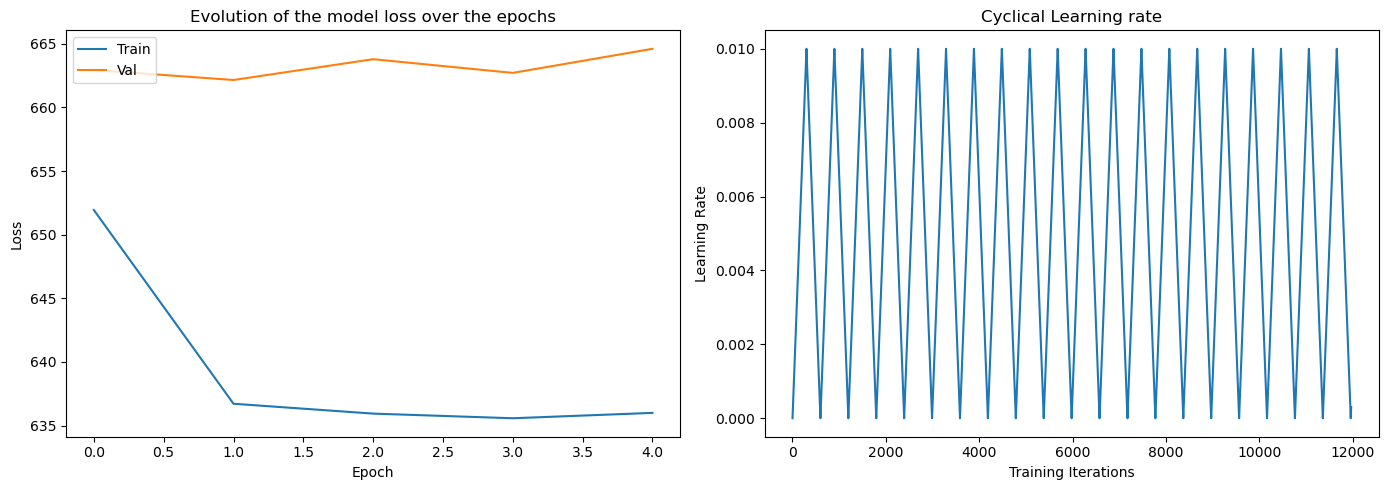

In [17]:
# Create a figure with 2 subplots side by side (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the error
ax1.plot(history.history['mean_absolute_error'])
ax1.plot(history.history['val_mean_absolute_error'])
ax1.set_title('Evolution of the model loss over the epochs')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

# Plot how the cyclical learning rate moves
ax2.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])
ax2.set_xlabel('Training Iterations')
ax2.set_ylabel('Learning Rate')
ax2.set_title("Cyclical Learning rate")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Model evaluation


In [18]:
loss, mean_absolute_error = model.evaluate(test_generator, steps = test_generator.n//batch_size)
print("Test MAE:", mean_absolute_error)

799/799 [==============================] - 1178s 1s/step - loss: 651.4871 - mean_absolute_error: 651.9863
Test MAE: 651.986328125


Adding the figure fitted vs actual
put a semicolon at the end to limit the output

In [19]:
pred = []

for i in range(len(test_label_df)):
    filename = test_label_df.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    price_difference = predictions[0][0] - test_label_df.iloc[i]["price"]
    pred.append({'price': predictions[0][0], 'difference': price_difference})

    #print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

price  difference
0  547.712830 -427.287170
1  607.041992 -367.958008
2  528.308960 -446.691040
3  595.916992 -379.083008
4  514.410889 -460.589111

Text(0.5, 0, 'Actual price')

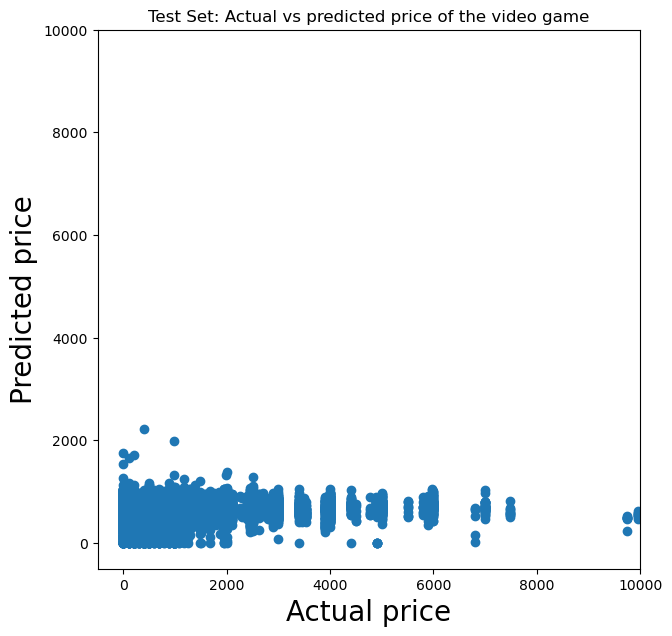

In [20]:
plt.figure(figsize = (7,7))
plt.axis([-500, 10000, -500, 10000])
plt.scatter(test_label_df['price'], predictions_test['price'])
plt.title("Test Set: Actual vs predicted price of the video game")
plt.ylabel("Predicted price", size=20)
plt.xlabel("Actual price", size=20)

In [21]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_label_df['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_label_df['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_label_df['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_label_df['price'], predictions_test['price']))

Mean Absolute Error: 651.8617731839707
Mean Squared Error: 1114464.4934305425
Root Mean Squared Error: 1055.6820039342067
R2 score: -0.07010361075037408


Add a distribution of the losses, to analyse where the losses are located.

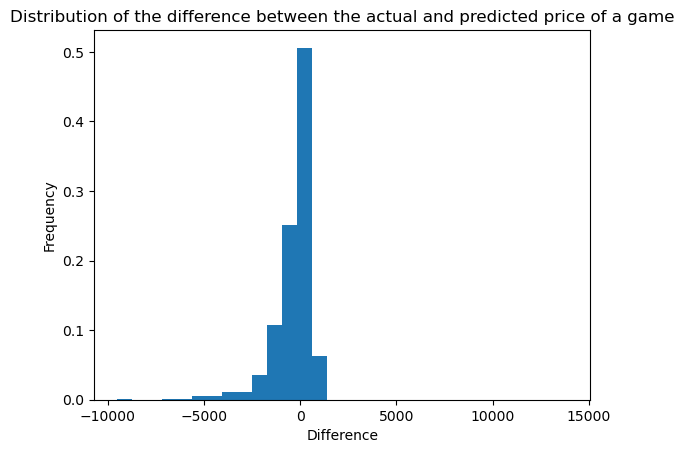

In [22]:
# Plot histogram of the differences in price
# Multiply y-axis values by 100 to represent percentages
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference between the actual and predicted price of a game')

# Show plot
plt.show()

### Examples of predictions for images

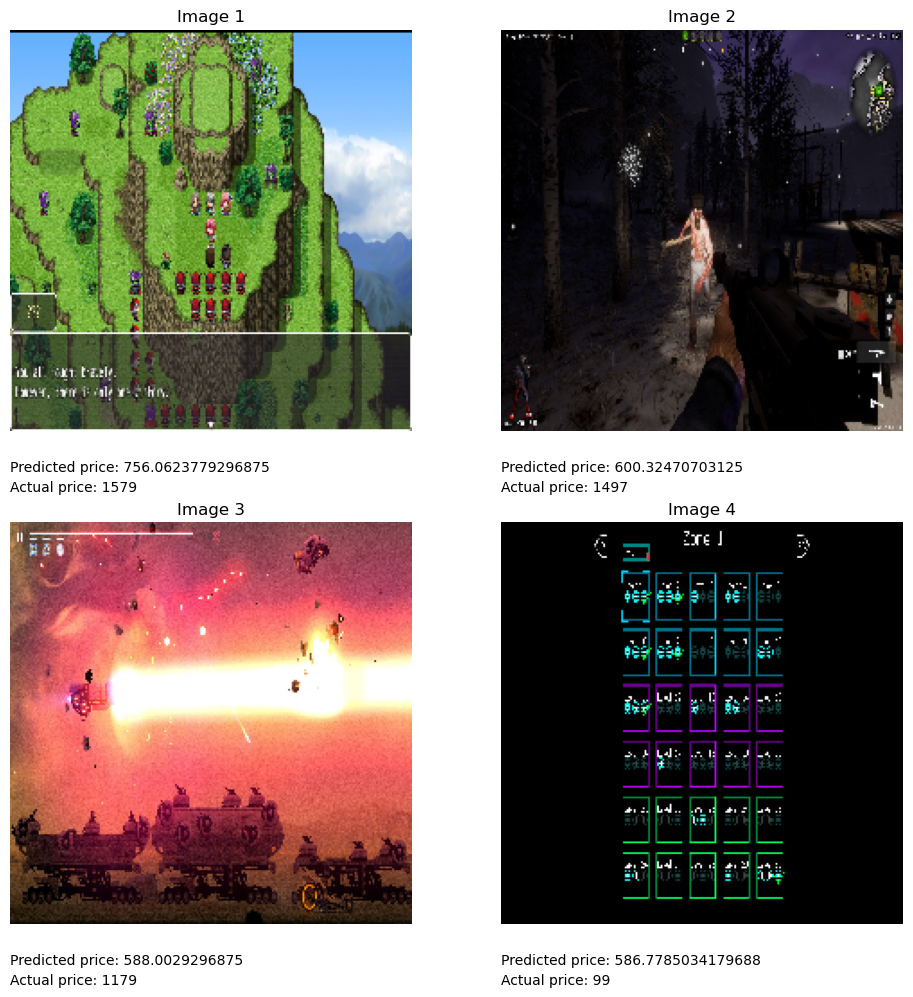

In [23]:
def display_images_with_predictions(image_numbers, test_label_df, image_location, model, height, width):
    num_images = len(image_numbers)
    num_rows = (num_images + 1) // 2  # Calculate number of rows needed for the grid
    
    plt.figure(figsize=(10, 10))  # Set figure size
    
    for i, number in enumerate(image_numbers, start=1):
        filename = test_label_df.loc[number, "screenshot"]
        image_path = os.path.join(image_location, filename)
        
        # Load and display the image
        img = keras.utils.load_img(image_path, target_size=(height, width))
        plt.subplot(num_rows, 2, i)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis('off')

        img_array = keras.utils.img_to_array(img)
        img_array = img_array / 255.0
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions_example = model.predict(img_array, verbose=0)[0][0]
        actual_price = test_label_df.loc[number, 'price']

        # Display predicted and actual price underneath the image
        plt.text(0, -0.1, f'Predicted price: {predictions_example}', transform=plt.gca().transAxes)
        plt.text(0, -0.15, f'Actual price: {actual_price}', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

# Example usage
image_numbers = [450, 500, 600, 700]  # Example list of image numbers
display_images_with_predictions(image_numbers, test_label_df, image_location, model, height, width)

### Interpretability using saliency plots

Building the saliency plots using the package from a Github repository https://github.com/keisen/tf-keras-vis/tree/master. 

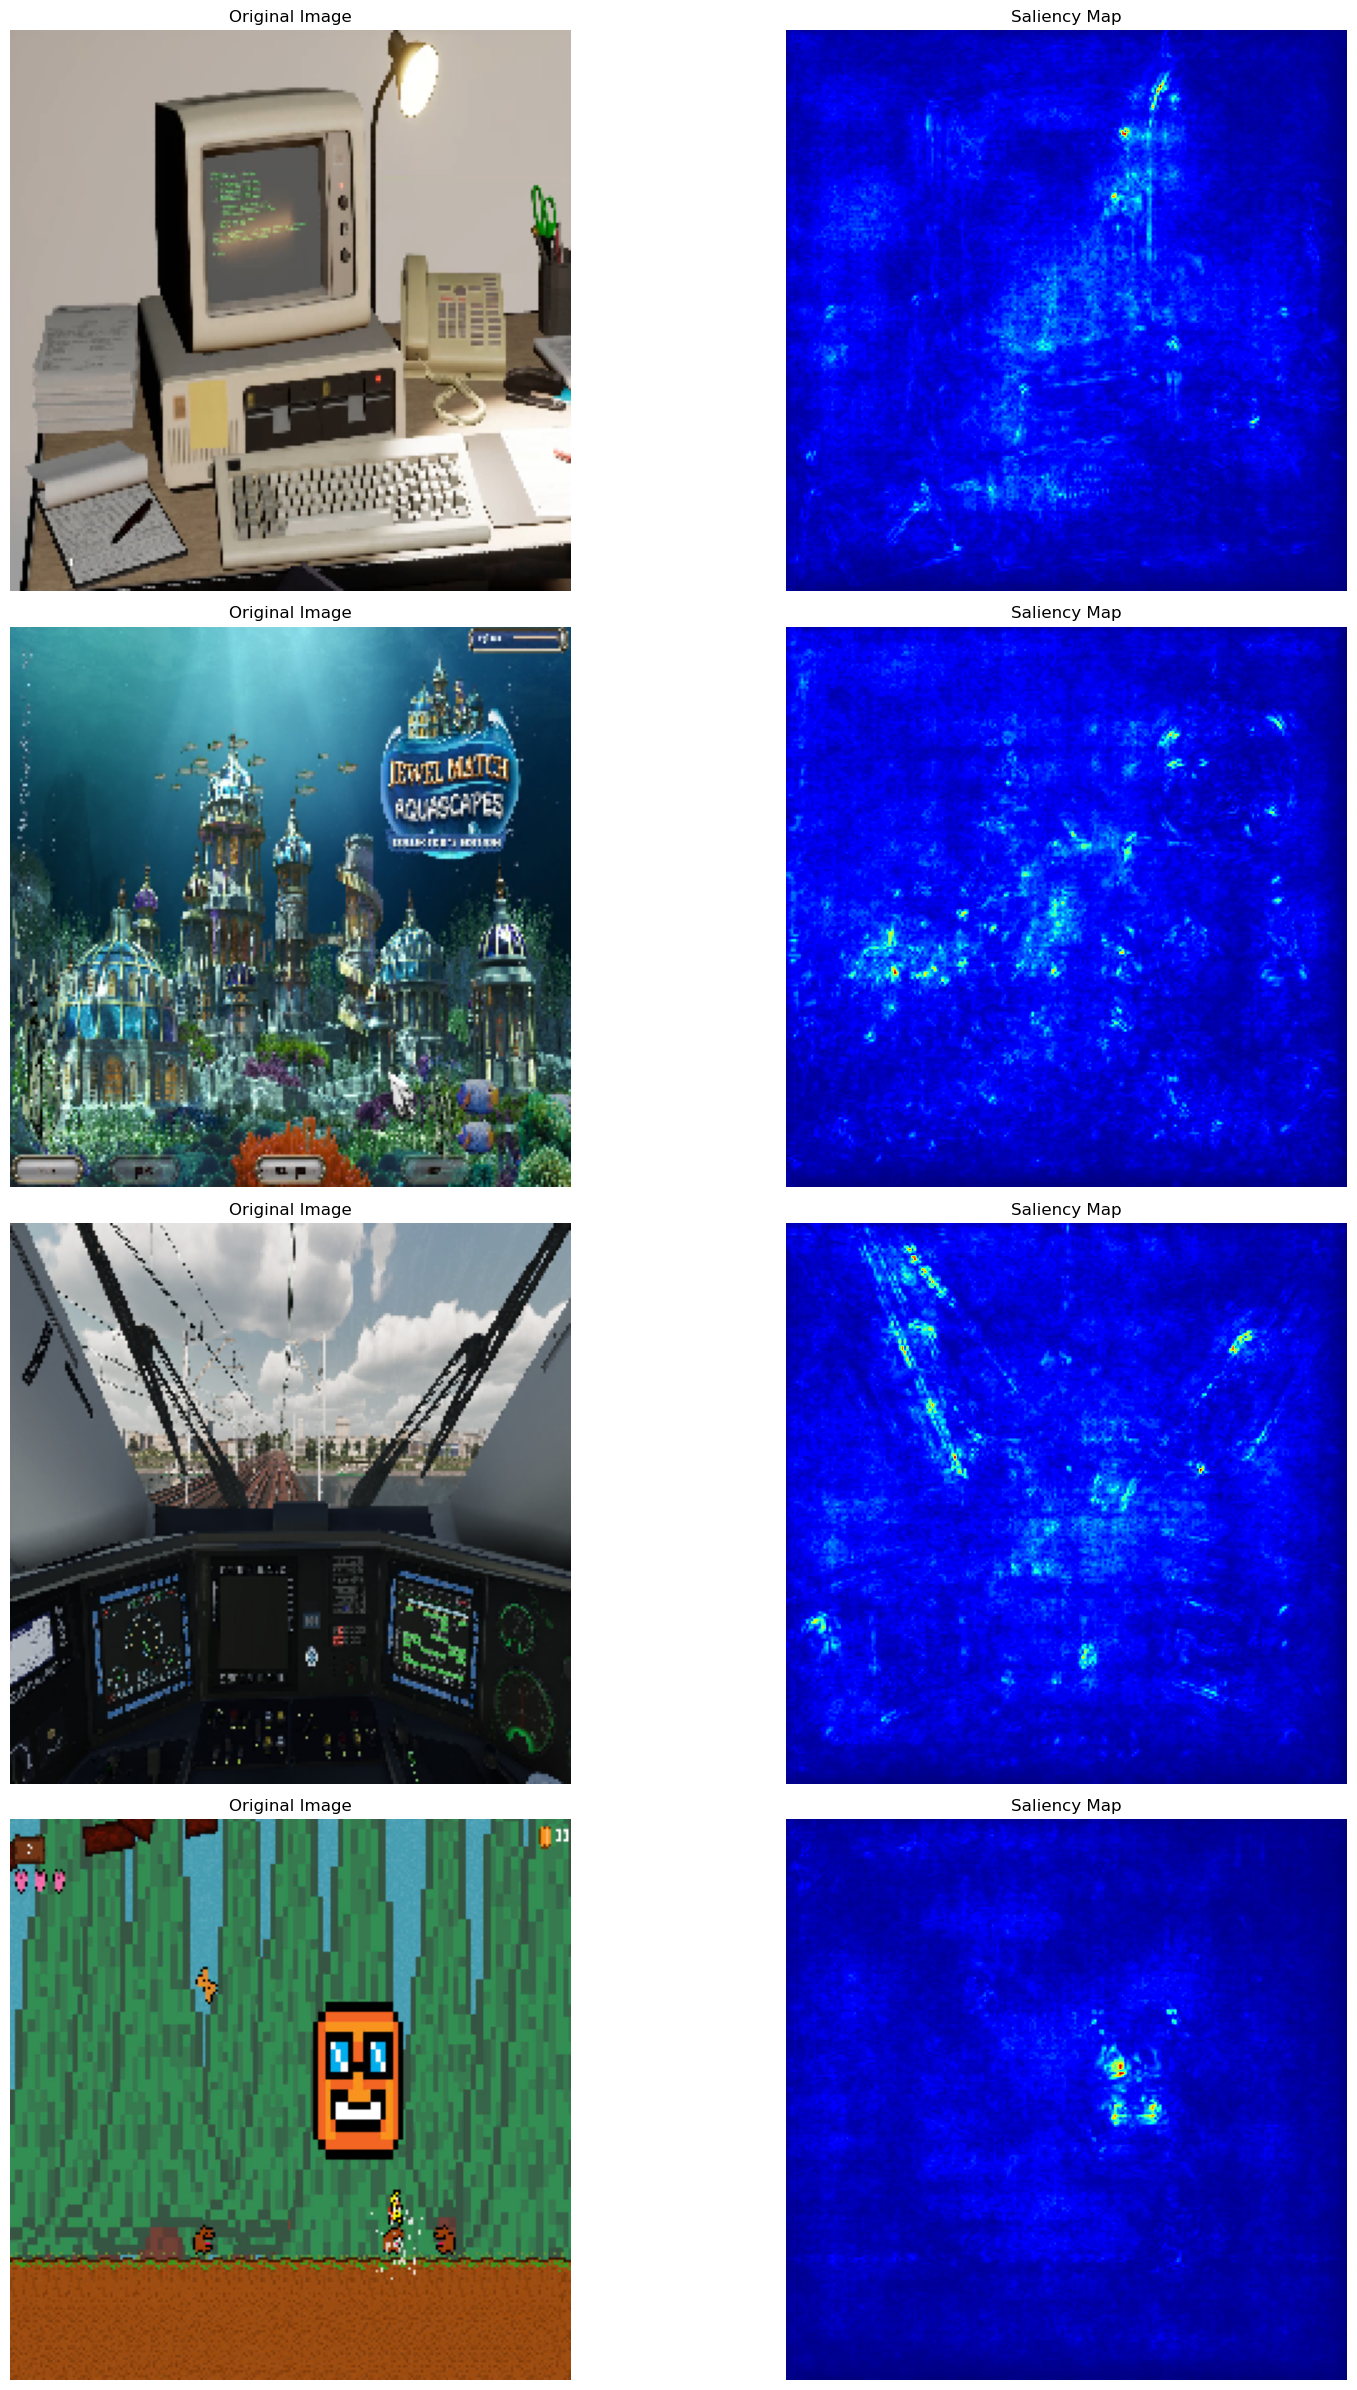

In [25]:
from matplotlib import pyplot as plt
import os
from tensorflow import keras

# Define the image location
numbers = [111, 567, 123, 999]  # Specify the numbers of the images to select
filenames = [test_label_df.loc[number, "screenshot"] for number in numbers]
prices = [test_label_df.loc[number, "price"] for number in numbers]

# Construct the full paths to the images
image_paths = [os.path.join(image_location, filename) for filename in filenames]

# Load the images
plt.rcParams['figure.figsize'] = (18, 24)

# Preprocess images, so that they are normalized
imgs = [keras.utils.load_img(image_path, target_size=(height, width)) for image_path in image_paths]
img_arrays = [keras.utils.img_to_array(img) / 255.0 for img in imgs]

# Model modifier: Such that the last layer has a linear activation function.
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()

# Score function: should return the target score
def score(output):
    return output[0][0]

from tf_keras_vis.saliency import Saliency

# Create Gradcam object
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM for each image
saliency_maps = []
for img_array in img_arrays:
    saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.20)
    saliency_maps.append(saliency_map[0])

# Plot the original images above their saliency maps in a 4x2 grid
f, ax = plt.subplots(4, 2)

for i in range(4):
    # Plot original image
    ax[i, 0].imshow(imgs[i])
    ax[i, 0].set_title(f"Original Image")
    ax[i, 0].axis('off')

    # Plot saliency map
    ax[i, 1].imshow(saliency_maps[i], cmap='jet')
    ax[i, 1].set_title(f"Saliency Map")
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 2. Multi-input CNN

### Pre-processing

The goal here is to create a dataset where each column contains the screenshot name

#### Developing the dataframe

In [ ]:
screenshots_new = selected_games_no_outliers['screenshots'].apply(pd.Series)
screenshots_new.head()

0   \
14542  2203540_ss_00e237a17c29f0b3f535be5bbaf1aca1291...   
2007   2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202  2263550_ss_003ae84254705fc2976b3302a9a7cad59d3...   
6681   2562290_ss_1279e5037cd663de37348356a3e0f49b230...   
12942  2299920_ss_068a09669ef97ddb9c79c2ca29ef7945dcc...   

                                                      1   \
14542  2203540_ss_1a1c09618fa769453a86ec361523bb56c87...   
2007   2747740_ss_391fdbf16da101beb045a88c28e038e0dc3...   
14202  2263550_ss_4ba42c4d41d345ce4ad54cdbaac74da3487...   
6681   2562290_ss_192326a1b1396941cef092ecdf82103a1ba...   
12942  2299920_ss_0a3f51dc8d1387c051bb0b6239ec3ee2ac2...   

                                                      2   \
14542  2203540_ss_2a7f60e28946eeba3f693cfbbcd911ce86f...   
2007   2747740_ss_3e21413e0407fc7a35f74faa17273690b10...   
14202  2263550_ss_55e8ffdfcac29d51e3477f128d04d5023e4...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_0ac1e97493ca3283d73e36bb9f00115c6d9...   

                                                      3   \
14542  2203540_ss_4bfd302dbed6cf7ea5918f0fc9889a4dfce...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_9e6120400646fc8c47512afd49979b3a92e...   
6681   2562290_ss_73fefb1fa059409880d1f416508a224dced...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...   

                                                      4   \
14542  2203540_ss_57481680e8c02e3dc6bc269e5543c36f407...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_f62c53d9cd31ca9c6599b9e50a37b86160b...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_33d9b7158ba8ae1019de2bd2277f147ab00...   

                                                      5   \
14542  2203540_ss_612dab69a97e6bc5e9e4e7a53b970248dbb...   
2007                                                 NaN   
14202  2263550_ss_fdd57a121c4bbd350261606d180f1a88221...   
6681                                                 NaN   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                      6   \
14542  2203540_ss_668b84bb5c268642426a986130de57492e6...   
2007                                                 NaN   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681                                                 NaN   
12942  2299920_ss_645d176075ee0ffc545f23adc5e31ca4948...   

                                                      7   \
14542  2203540_ss_773a259226938c797b7e2702c20a528844b...   
2007                                                 NaN   
14202                                                NaN   
6681                                                 NaN   
12942                                                NaN   

                                                      8   \
14542  2203540_ss_80e1925f5f07f07a88346d7b2bc898da97b...   
2007                                                 NaN   
14202                                                NaN   
6681                                                 NaN   
12942                                                NaN   

                                                      9   ...   75   76   77  \
14542  2203540_ss_bd0722a3320e860f06ee6b275693fc0044a...  ...  NaN  NaN  NaN   
2007                                                 NaN  ...  NaN  NaN  NaN   
14202                                                NaN  ...  NaN  NaN  NaN   
6681                                                 NaN  ...  NaN  NaN  NaN   
12942                                                NaN  ...  NaN  NaN  NaN   

        78   79   80   81   82   83   84  
14542  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2007   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
14202  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6681   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
12942  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 85 columns]

Fill in the NaNs with other screenshots. So that in the end have inputs of normal size. The images in the other columns are selected at random from the previous columns. 

In [ ]:
# Function to replace NaN values with a random non-NaN value from previous columns
def replace_nan_with_random(df):
    for index, row in df.iterrows():
        for col_index, value in row.items():
            if pd.isnull(value):
                # Get previous non-NaN values in the row
                previous_values = row[:col_index][::-1]
                previous_values = previous_values.dropna()
                
                if not previous_values.empty:
                    # Select a random non-NaN value from previous columns
                    random_value = previous_values.sample().iloc[0]
                    # Replace NaN with the randomly selected value
                    df.at[index, col_index] = random_value

# Call the function to replace NaN values with random non-NaN values
replace_nan_with_random(screenshots_new)

# Add the price
result_df = pd.concat([selected_games_no_outliers['price'], screenshots_new], axis=1)
result_df.head()

price                                                  0  \
14542    399  2203540_ss_00e237a17c29f0b3f535be5bbaf1aca1291...   
2007       0  2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202      0  2263550_ss_003ae84254705fc2976b3302a9a7cad59d3...   
6681     499  2562290_ss_1279e5037cd663de37348356a3e0f49b230...   
12942    499  2299920_ss_068a09669ef97ddb9c79c2ca29ef7945dcc...   

                                                       1  \
14542  2203540_ss_1a1c09618fa769453a86ec361523bb56c87...   
2007   2747740_ss_391fdbf16da101beb045a88c28e038e0dc3...   
14202  2263550_ss_4ba42c4d41d345ce4ad54cdbaac74da3487...   
6681   2562290_ss_192326a1b1396941cef092ecdf82103a1ba...   
12942  2299920_ss_0a3f51dc8d1387c051bb0b6239ec3ee2ac2...   

                                                       2  \
14542  2203540_ss_2a7f60e28946eeba3f693cfbbcd911ce86f...   
2007   2747740_ss_3e21413e0407fc7a35f74faa17273690b10...   
14202  2263550_ss_55e8ffdfcac29d51e3477f128d04d5023e4...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_0ac1e97493ca3283d73e36bb9f00115c6d9...   

                                                       3  \
14542  2203540_ss_4bfd302dbed6cf7ea5918f0fc9889a4dfce...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_9e6120400646fc8c47512afd49979b3a92e...   
6681   2562290_ss_73fefb1fa059409880d1f416508a224dced...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...   

                                                       4  \
14542  2203540_ss_57481680e8c02e3dc6bc269e5543c36f407...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_f62c53d9cd31ca9c6599b9e50a37b86160b...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_33d9b7158ba8ae1019de2bd2277f147ab00...   

                                                       5  \
14542  2203540_ss_612dab69a97e6bc5e9e4e7a53b970248dbb...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_fdd57a121c4bbd350261606d180f1a88221...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                       6  \
14542  2203540_ss_668b84bb5c268642426a986130de57492e6...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681   2562290_ss_192326a1b1396941cef092ecdf82103a1ba...   
12942  2299920_ss_645d176075ee0ffc545f23adc5e31ca4948...   

                                                       7  \
14542  2203540_ss_773a259226938c797b7e2702c20a528844b...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_55e8ffdfcac29d51e3477f128d04d5023e4...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...   

                                                       8  ...  \
14542  2203540_ss_80e1925f5f07f07a88346d7b2bc898da97b...  ...   
2007   2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...  ...   
14202  2263550_ss_4ba42c4d41d345ce4ad54cdbaac74da3487...  ...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...  ...   
12942  2299920_ss_0ac1e97493ca3283d73e36bb9f00115c6d9...  ...   

                                                      75  \
14542  2203540_ss_2a7f60e28946eeba3f693cfbbcd911ce86f...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_003ae84254705fc2976b3302a9a7cad59d3...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_645d176075ee0ffc545f23adc5e31ca4948...   

                                                      76  \
14542  2203540_ss_bd0722a3320e860f06ee6b275693fc0044a...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_9e6120400646fc8c47512afd49979b3a92e...   
6681   2562290_ss_1279e5037cd663de37348356a3e0f49b230...   
12942  2299920_ss_23e3a1d

#### Train - test split

Need to redo the train-test split because we are working with a different dataset than in method 1

In [ ]:
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(result_df, test_size=0.2, random_state=42)
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2
#train_games.head()

Create a function that allows us to specify how many columns should be considered.

In [ ]:
def generate_generator_multiple(generator, dataframe, batch_size, img_height, img_width, num_columns=7):
    generators = []
    
    for i in range(num_columns):
        genX = generator.flow_from_dataframe(dataframe=dataframe, directory=image_location, color_mode="rgb",
                                             target_size=(img_height, img_width),
                                             x_col=i, y_col="price", has_ext=True,
                                             class_mode="other",
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=7)
        generators.append(genX)
       

    while True:
        batch_X = []
        batch_Y = None
        
        for genX in generators:
            X, Y = genX.next()
            batch_X.append(X)
            if batch_Y is None:
                batch_Y = Y
        
        yield batch_X, batch_Y

In [ ]:
inputgenerator=generate_generator_multiple(generator=train_datagen, dataframe=train_games,
                                           batch_size=batch_size,
                                           img_height=height,
                                           img_width=width)       

valgenerator=generate_generator_multiple(val_datagen, dataframe=val_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)   
     
testgenerator=generate_generator_multiple(test_datagen, dataframe=test_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)

### Architecture

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import activations


input_x_1 = Input(shape=(224, 224, 3), name='input_1')
input_x_2 = Input(shape=(224, 224, 3), name='input_2')
input_x_3 = Input(shape=(224, 224, 3), name='input_3')
input_x_4 = Input(shape=(224, 224, 3), name='input_4')
input_x_5 = Input(shape=(224, 224, 3), name='input_5')
input_x_6 = Input(shape=(224, 224, 3), name='input_6')
input_x_7 = Input(shape=(224, 224, 3), name='input_7')


#Shared layer
base_model = ResNet50(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    input_shape= (224, 224, 3),
    pooling=None
)
base_model.trainable = False


x1 = base_model(input_x_1, training=False)
x2 = base_model(input_x_2, training=False)
x3 = base_model(input_x_3, training=False)
x4 = base_model(input_x_4, training=False)
x5 = base_model(input_x_5, training=False)
x6 = base_model(input_x_6, training=False)
x7 = base_model(input_x_7, training=False)


x = Concatenate()([x1, x2, x3, x4, x5, x6, x7])

# Add a layer on top
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3, name="top_dropout")(x)
x = BatchNormalization()(x)
# inspired by https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/ 
outputs = Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = Model(inputs= [input_x_1, input_x_2, input_x_3, input_x_4, input_x_5, input_x_6, input_x_7], outputs= outputs)


To do: add nice image with the architecture 

In [ ]:
from keras.utils import plot_model
import pydot
#plot_model(model, "Method2.png", show_shapes=True)
#model.summary()

from IPython.display import Image

# Display the image with a relative path
Image(filename='Method2.png')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [ ]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam, SGD

#set the CLR options
clr_step_size = int(4 * (len(train_games)/batch_size)) #see paper https://arxiv.org/pdf/1506.01186
base_lr = 1e-7
max_lr = 5e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0007)

# Adding an early stopping mechanism
EarlyStopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    start_from_epoch=3)

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")

Model is compiled


### Fitting the model

In [ ]:
# Fitting the model

history = model.fit(
    inputgenerator,
    steps_per_epoch=len(train_games)//batch_size,
    epochs=5,
    validation_data=valgenerator,
    validation_steps = len(val_games)//batch_size, 
    callbacks = [EarlyStopping_cb , clr_triangular]
)

Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Epoch 1/5
181/273 [==================>...........] - ETA: 18:06 - loss: 713.7830 - mean_absolute_error: 713.7830

KeyboardInterrupt: 

In [ ]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model evaluation

In [ ]:
# Evaluate model
loss, mean_absolute_error = model.evaluate(testgenerator, steps=len(test_games)//batch_size)

In [ ]:
pred = []

for i in range(len(test_games)):

    image_paths = [os.path.join(image_location, filename) for filename in test_games.iloc[i, 1:9]]  # Assuming columns "0" to "8" contain the image filenames
    images = [keras.utils.load_img(image_path, target_size=(224, 224)) for image_path in image_paths]

    img_arrays = [keras.utils.img_to_array(img) for img in images]
    img_arrays = [img_array / 255.0 for img_array in img_arrays]
    img_arrays = [tf.expand_dims(img_array, 0) for img_array in img_arrays]  # Create batch axis for each image


    predictions = model.predict(img_arrays, verbose=0)
    price_difference = predictions[0][0] - test_games.iloc[i]['price']
    pred.append({'price': predictions[0][0], 'difference': price_difference})
    print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

In [ ]:
plt.figure(figsize = (7,7))
plt.axis([-100, 1000, -100, 1000])
plt.scatter(test_games['price'], predictions_test['price'])

plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))

TO DO: add a distribution with the losses, to analyse what the biggest losses are

In [ ]:
# Plot histogram of the differences in price
# Multiply y-axis values by 100 to represent percentages
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference between the actual and predicted price of a game')

# Show plot
plt.show()

## 3. Stitched images

The following part attempts to predict the price of a game based on one input of multiple screenshots. The screenshots will be stitched together per game. As in the part before a prediction was made for every screenshot without a link to the other screenshots of the game. This part tries to improve the model by linking all screenshots together and giving one input per game. 
<br>
The image below shows an example of a stitched image.

In [3]:
#read in dataframe that contains the name of the first screenshot used in the stitching of the images and the price of the game. 
df = pd.read_csv('stitched_price.csv')

image_location = 'D:/images/stitched'


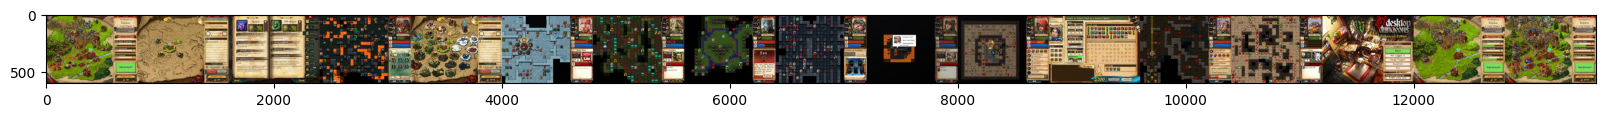

In [4]:
import matplotlib.image as mpimg

image_path = 'D:/images/stitched/226620_ss_08d910d405bfbdd6a5b81f69a4f9b85a66cb0bc5.1920x1080.jpg'  

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(20,7))
plt.imshow(img)
plt.show()

### preprocessing

#### Removing outliers

Because of the new dataframe the preprocessing has to be repeated. 

In [5]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(df)*0.15)
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = df.sample(n=num_selected_games)

In [6]:
# Remove the games that have a price larger than 100 USD from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]
# The dataset also includes 'bundle' games. these bundles contain multiple games. They have a very high price. As they are not in the scope of this model they are removed.
# selected_games_no_outliers = selected_games_no_outliers[selected_games_no_outliers['price'] >= 100]


Sarah: staat al bovenaan. Mag eigenlijk weg hier want het is herhaling 

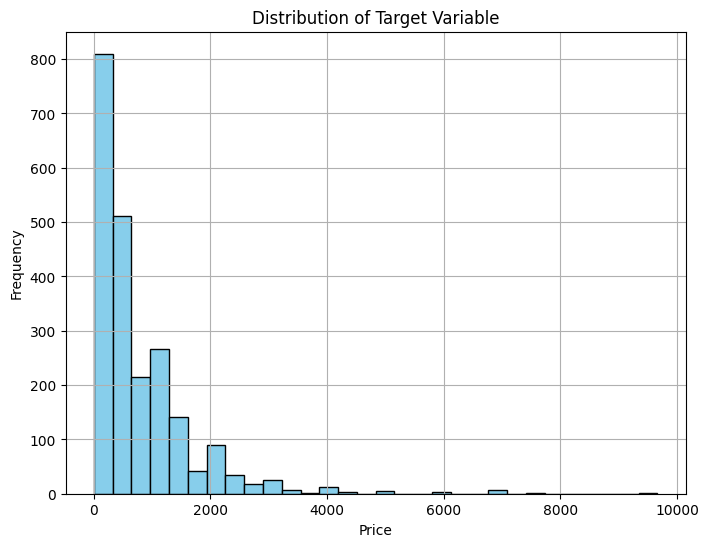

In [7]:
# Assuming 'target_variable' is the name of your target variable column in the dataframe 'data'
target_variable = selected_games_no_outliers['price']

plt.figure(figsize=(8, 6))
plt.hist(target_variable, bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Target Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Train-test split

Re-do train test split because are working with a different dataframe than the original json file

In [8]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

In [9]:
val_games['price'] = val_games['price'].astype('float32')
test_games['price'] = test_games['price'].astype('float32')
train_games['price'] =train_games['price'].astype('float32')

In [10]:
train_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 7457 to 13463
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   screenshot  1317 non-null   object 
 1   price       1317 non-null   float32
dtypes: float32(1), object(1)
memory usage: 25.7+ KB


### Model setup

The model is setup with the ImageDataGenerator. This takes care of the data augmentation. Later the model is build on the transfer learning principle. The CNN model is trained on top of a pretrained model. Here ResNet50 from the Keras library is used. <br>
Then a convolutional layer is added to filter more features from the images. Additionally, Maxpooling is used to downsample. Several attempts have been made to add more convolutional layers. However this was not possible as problems with the shape of the image size arose. Later a dropout layer is added to prevent overfitting. The flatten layer maps the 2D vectors to a 1D vector. The dense layers connect the features to one continous output.

Sarah: die train_datagen is hetzelfde gebleven, dus je mag dat in dit deel weglaten.

In [11]:
#create a training datagenerator, including data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="raw", target_size=(224, 224), 
                                              batch_size=32)



# same for the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

val_generator = test_datagen.flow_from_dataframe(dataframe=val_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="raw", target_size=(224, 224), 
                                              batch_size=32)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)


Found 1317 validated image filenames.
Found 439 validated image filenames.
Found 439 validated image filenames.


In [12]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

# Freeze the base model
base_model.trainable = False
# model = Sequential([base_model])
# Add layers to the base model
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(224,224, 3)), #add multiple convolution layers
    MaxPooling2D((2, 2)),
    # Conv2D(32, (3, 3), activation='relu', padding = "same"),
    # MaxPooling2D((2, 2)),
    # Conv2D(32, (3, 3), activation='relu', padding = "same"),
    # MaxPooling2D((2, 2)),
    Dropout(0.20),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

Sarah: hier nog de architecture inzetten.

In [ ]:
from keras.utils import plot_model
import pydot
#plot_model(model, "Method3.png", show_shapes=True)
#model.summary()

from IPython.display import Image

# Display the image with a relative path
Image(filename='Method3.png')

In [13]:
# Compile model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1, 
    validation_data=val_generator,
    validation_steps=len(val_generator)
)




c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 272s 6s/step - loss: 644.0746 - mae: 648.2695 - val_loss: 576.8468 - val_mae: 576.5661
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 588.0305 - mae: 587.6568
Validation Mean Absolute Error: 576.5662231445312


Figure with the evolution of the loss across the epochs

In [ ]:
# Plotting the error
ax1.plot(history.history['mean_absolute_error'])
ax1.plot(history.history['val_mean_absolute_error'])
ax1.set_title('Evolution of the model loss over the epochs')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

In [ ]:
# Evaluate model
loss, mae = model.evaluate(test_generator)
print("Validation Mean Absolute Error:", mae)

# Save the model
model.save("fullModel_3epochs.keras")

### Testing

The following part predicts the price for each stitched image in the test set. Later some metrics are calculated and a graph is plotted. Based on these it's clear the model does not function properly. It is not clear why the model only predicts in a very limited interval. 
<br>
Several attempts were made to create a better model. The following concepts were tried but didn't give better predictions:
- Duplicating images to get an equal image width
- Loss functions: Mean Squared Logarithmic Error, MAE, Huber
- Transform it into a classification problem with 'price ranges', combined with over/undersampling
- Logtransformation of the prices because of the right skewed 'price' distribution
<br>

A saliency map is added for interpretability. No insights can be extracted from these to explain the bad predictions.

In [14]:
# model = keras.models.load_model("my_model.keras")

pred = []

for i in range(len(test_games)):
    filename = test_games.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)

    pred.append({'price': predictions[0][0]})

    print('difference ', i , predictions[0][0] - test_games.iloc[i]["price"])

predictions_test = pd.DataFrame(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
difference  0 -44.002563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
difference  1 316.5874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
difference  2 135.16791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
difference  3 -180.17853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
difference  4 191.88354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
difference  5 -759.025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
difference  6 272.19193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
difference  7 174.14859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
difference  8 375.328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
difference  9 -969.8419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
difference  10 -1298.081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
difference  11 -488.36227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
difference  12 196.68497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
difference  13 -1046.8953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
difference  14 -807.40015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
difference  15 

In [15]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))
print('Mean absolute percentage error:', metrics.mean_absolute_percentage_error(test_games['price'], predictions_test['price']))

Mean Absolute Error: 620.5611
Mean Squared Error: 1211155.5
Root Mean Squared Error: 1100.5251
R2 score: -0.10580945049521051
Mean absolute percentage error: 2.8798744e+17


Text(0.5, 0, 'Actual')

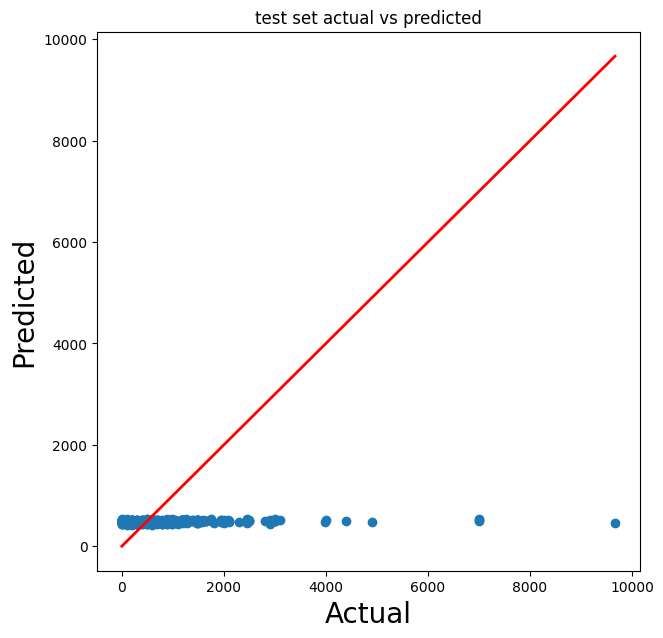

In [16]:
# plot the predicted vs actual values
plt.figure(figsize = (7,7))
plt.scatter(test_games['price'], predictions_test['price'])
plt.plot([min(test_games['price']), max(test_games['price'])], [min(test_games['price']), max(test_games['price'])], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

D:/images/stitched\2479990_ss_03262c5a2f5fd4b0e094d06415500b1e385b47e5.1920x1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[477.15244]]
477


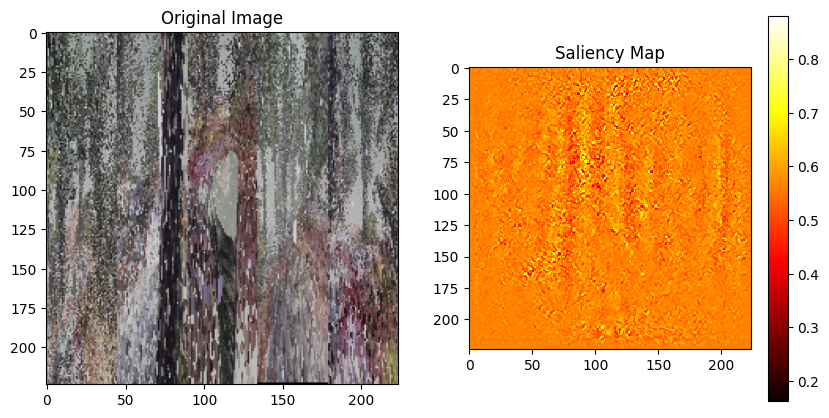

In [39]:
from tensorflow.keras.preprocessing import image

filename = test_games.iloc[50]["screenshot"]
img_path = os.path.join(image_location, filename)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model's input


img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalization if required by your model

# Make a prediction
predictions = model.predict(img_array)
predicted_class = int(predictions[0][0])
print(predicted_class)
img_tensor = tf.convert_to_tensor(img_array)

# Compute the gradient of the output with respect to the input image
with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    # For regression, assume predictions is a scalar value
    loss = predictions[0]

grads = tape.gradient(loss, img_tensor)
grads = tf.reduce_mean(grads, axis=0)

# Process the gradients to generate the saliency map
grad_max = tf.reduce_max(grads)
grad_min = tf.reduce_min(grads)
grads = (grads - grad_min) / (grad_max - grad_min)  # Normalize between 0 and 1
grads = tf.clip_by_value(grads, 0, 1)  # Clip values to [0, 1] range

# Convert to numpy array for visualization
grads = grads.numpy()
saliency_map = np.mean(grads, axis=-1)

# Plot the original image and the saliency map
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.show()

## Conclusion

X performs best. 
Must be careful when comparing method 1 to method 2 & 3 because other evaluation methods are used. Model 1 based on indivudal images whereas Model 2 & 3 based on games